In [1]:
from plotnine import *
import lmfit
%matplotlib inline
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from rich.progress import track
import statsmodels
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch
import numpy as np
import os

In [2]:
print(statsmodels.__version__)

0.13.2


In [3]:
genpath='/proj/gibbons/kramos/github/IBT-and-the-Gut-Microbiome/'

### Testing different simulation parameters

Text(0.0, 1.0, 'b')

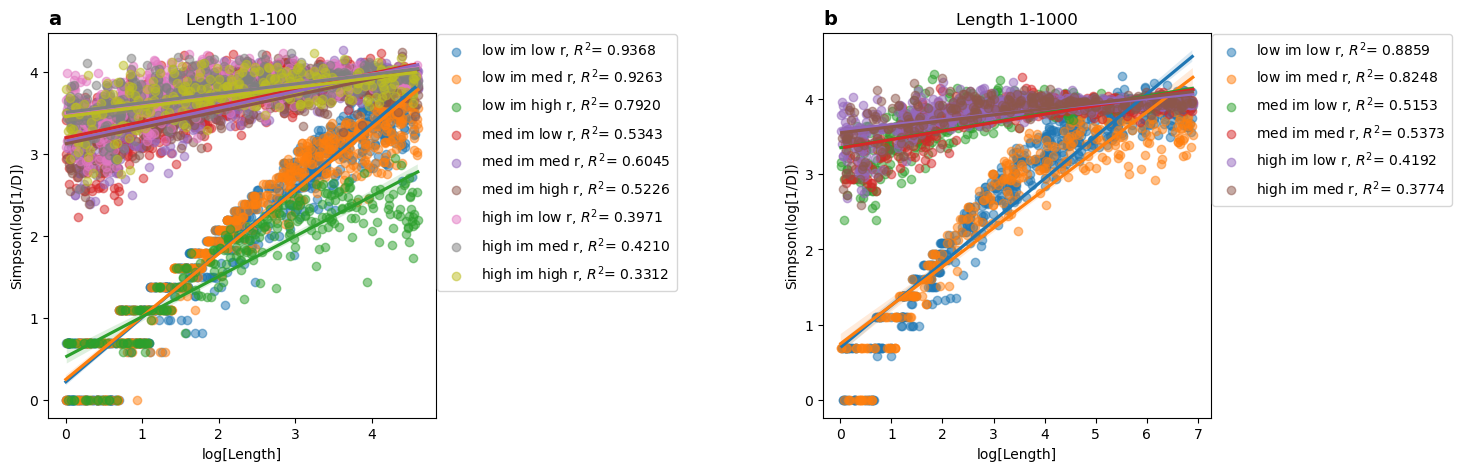

In [4]:
formula = 'Simpson ~ Length'

fig,axs = plt.subplots(1,2,figsize=(15,5))
plt.subplots_adjust(wspace=1)

folder_location = '/proj/gibbons/kramos/github/IBT-and-the-Gut-Microbiome/IBM/data/small_tests_1-100/'

for file in os.listdir(folder_location): 
    df = pd.read_csv(folder_location + file)
    features = ['Simpson', 'Length'] 
    df[features] = df[features].apply(lambda x: np.log(x))
    x = 'Length'
    y = 'Simpson'
    fitted = ols(formula, data=df).fit()
    r_squared = fitted.rsquared
    info = file.replace('.csv', '').replace('_', ' ') + f', $R^2$= {r_squared:.4f}'
    
    axs[0]=sns.regplot(data=df, x=x, y=y,label = info, scatter_kws={'alpha':0.5}, ax = axs[0])
    axs[0].set_xlabel('log[Length]')
    axs[0].set_ylabel('Simpson(log[1/D])')
    axs[0].set_title('Length 1-100')
    axs[0].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)

folder_location = '/proj/gibbons/kramos/github/IBT-and-the-Gut-Microbiome/IBM/data/large_tests_1-1000/'
for file in os.listdir(folder_location): 
    df = pd.read_csv(folder_location + file)
    features = ['Simpson', 'Length'] 
    df[features] = df[features].apply(lambda x: np.log(x))
    x = 'Length'
    y = 'Simpson'
    fitted = ols(formula, data=df).fit()
    r_squared = fitted.rsquared
    info = file.replace('.csv', '').replace('_', ' ') + f', $R^2$= {r_squared:.4f}'
    
    axs[1]=sns.regplot(data=df, x=x, y=y,label = info, scatter_kws={'alpha':0.5}, ax = axs[1])
    axs[1].set_xlabel('log[Length]')
    axs[1].set_ylabel('Simpson(log[1/D])')
    axs[1].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.1)
    axs[1].set_title('Length 1-1000')
    
axs[0].set_title('a',loc='left', fontweight='bold', fontsize=14) 
axs[1].set_title('b',loc='left', fontweight='bold', fontsize=14) 


In [5]:
fig.savefig(genpath+'output/static_sim_data.pdf', bbox_inches='tight')

### Plot the results from my simulated data

In [58]:
# human=pd.read_csv(genpath+'/IBM/final/h_1000/simData.csv')
# human = pd.read_csv(genpath+'humans_L50-100_LMimr_LMr.csv')
human = pd.read_csv(genpath+'/IBM/data/L50-100_Mimr_Mr.csv').dropna()
# human = pd.read_csv(genpath + 'humans_L5-10_LMimr_LMr.csv')
# animal= pd.read_csv(genpath+'/IBM/final/a_1000/simData.csv')
animal=pd.read_csv(genpath+'IBM/data/L1-1000_Mimr_Mr.csv').dropna()
# animal=pd.read_csv(genpath+'IBM/data/test.csv').dropna()
# animal = pd.read_csv('/proj/gibbons/kramos/github/IBT-and-the-Gut-Microbiome/IBM/data/test_L1-1000_medim_medR.csv')
# animal=pd.read_csv(genpath+'vertebrates_L1-1000_LMimr_LMr.csv')

In [59]:
animal.describe()

,sim,ct,Length,TotalAbundance,SpeciesRichness,Simpson,Simpson_e
count,4.000000,4.00,4.000000,4.000000,4.000000,4.000000,4.000000
mean,1.500000,1017.25,88.361516,15413.500000,664.500000,47.359903,0.281745
std,1.290994,36.50,158.270783,30353.770447,1044.319396,6.519061,0.219379
min,0.000000,999.00,5.557947,129.000000,91.000000,39.104408,0.020658
25%,0.750000,999.00,9.053230,229.500000,144.250000,44.326981,0.172755
50%,1.500000,999.00,11.077420,290.500000,168.500000,47.871233,0.280223
75%,2.250000,1017.25,90.385706,15474.500000,688.750000,50.904155,0.389213
max,3.000000,1072.00,325.733275,60944.000000,2230.000000,54.592739,0.545875


In [22]:
human.describe()

,sim,ct,Length,TotalAbundance,SpeciesRichness,Simpson,Simpson_e
count,999.000000,999.0,999.000000,999.000000,999.000000,999.000000,999.000000
mean,499.874875,999.0,72.568938,2716.418418,755.164164,49.983568,0.067761
std,288.720589,0.0,14.883310,785.767676,119.956652,4.718580,0.011971
min,0.000000,999.0,50.035535,1607.000000,533.000000,36.153592,0.041951
25%,250.500000,999.0,59.240563,2013.000000,653.000000,46.745767,0.058285
50%,500.000000,999.0,71.054235,2566.000000,744.000000,49.780990,0.066210
75%,749.500000,999.0,85.582949,3382.000000,860.000000,52.989022,0.076178
max,999.000000,999.0,99.948252,4343.000000,1014.000000,66.567298,0.106950


In [42]:
animal=animal[np.isfinite(animal)==True]
human=human[np.isfinite(human)==True]

In [43]:
features=['Length', 'Simpson']
human[features]=human[features].apply(lambda x: np.log(x))
animal[features]=animal[features].apply(lambda x: np.log(x))

In [44]:
human.describe()

,sim,ct,Length,TotalAbundance,SpeciesRichness,Simpson,Simpson_e
count,999.000000,999.0,999.000000,999.000000,999.000000,999.000000,999.000000
mean,499.874875,999.0,4.263353,2716.418418,755.164164,3.907257,0.067761
std,288.720589,0.0,0.206542,785.767676,119.956652,0.094290,0.011971
min,0.000000,999.0,3.912733,1607.000000,533.000000,3.587776,0.041951
25%,250.500000,999.0,4.081606,2013.000000,653.000000,3.844724,0.058285
50%,500.000000,999.0,4.263443,2566.000000,744.000000,3.907633,0.066210
75%,749.500000,999.0,4.449486,3382.000000,860.000000,3.970085,0.076178
max,999.000000,999.0,4.604653,4343.000000,1014.000000,4.198213,0.106950


In [45]:
animal.describe()

,sim,ct,Length,TotalAbundance,SpeciesRichness,Simpson,Simpson_e,Unnamed: 7
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
def get_results(feature):
    """Get a single association.
    
    As long as `args` and `df` are assigned this can be used on
    any data set.
    """
    formula = f"{feature} ~ Length"
    fitted = ols(formula, data=df).fit()
    return pd.DataFrame({
        "feature": feature,
        "beta": fitted.params["Length"],
        "t_statistic": fitted.tvalues["Length"],
        "p": fitted.pvalues["Length"],
        "n": fitted.nobs, 
        'rsquared':fitted.rsquared
        }, index=[feature])

args=['Simpson']

In [47]:
df = human
results = map(get_results, track(args))
results = list(results)
human_tests = pd.concat(results)
human_tests["q"] = multipletests(human_tests.p, method="fdr_bh")[1]
human_tests['data']='human'

In [48]:
df = animal
results = map(get_results, track(args))
results = list(results)
animal_tests = pd.concat(results)
animal_tests["q"] = multipletests(animal_tests.p, method="fdr_bh")[1]
animal_tests['data']='animal'

all_tests=pd.concat([animal_tests, human_tests])
all_tests

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
all_tests=all_tests.set_index('data')
all_tests

In [49]:
animal = animal.dropna()
animal.head()

,sim,ct,Length,TotalAbundance,SpeciesRichness,Simpson,Simpson_e,Unnamed: 7


In [32]:
a_p=all_tests.loc['animal', 'p']
a_p= f'p={a_p:.2E}'
a_rsq=all_tests.loc['animal', 'rsquared']
h_p=all_tests.loc['human', 'p']
h_p=f'p={h_p:.2E}'
h_rsq=all_tests.loc['human', 'rsquared']

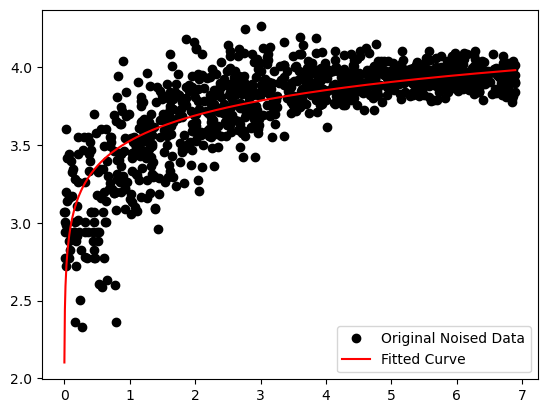

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.odr
import scipy.stats

def func(x, a, b, c):
  # return a * np.exp(-b * x) + c
    return a * np.log(b * x) + c
  

data = animal[['Length', 'Simpson']].sort_values(by='Length')
x,y=data['Length'], data['Simpson']
popt, pcov = curve_fit(func, x, y)

plt.figure()
plt.plot(x, y, 'ko', label="Original Noised Data")
plt.plot(x, func(x, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

In [34]:
animal['Length']

1      0.008678
2      1.256763
3      2.109895
4      0.869604
5      1.599258
         ...   
995    6.863379
996    6.755293
997    6.627130
998    5.446020
999    6.762886
Name: Length, Length: 999, dtype: float64

[[Model]]
    Model(func_log)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 56
    # data points      = 999
    # variables        = 3
    chi-square         = 29.5761533
    reduced chi-square = 0.02969493
    Akaike info crit   = -3510.26659
    Bayesian info crit = -3495.54632
    R-squared          = 0.68670576
[[Variables]]
    a: -1.03730424 +/- 0.02381064 (2.30%) (init = 0.2355187)
    b:  0.67081840 +/- 0.03379776 (5.04%) (init = 1.61611)
    c:  3.96332859 +/- 0.01132951 (0.29%) (init = 3.41215)
[[Correlations]] (unreported correlations are < 0.100)
    C(b, c) = -0.7770
    C(a, b) = -0.3614


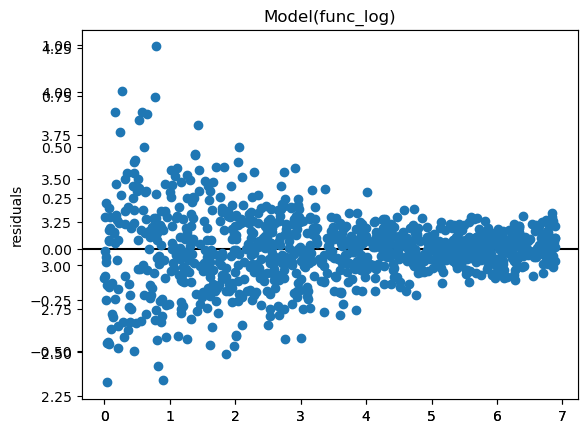

In [35]:
def func_log(x, a, b, c):
    """Return values from a general log function."""
    # return a * np.log(b * x) + c
    return a * np.exp(-b * x) + c


data = animal[['Length', 'Simpson']].sort_values(by='Length')
x_samp,y_samp=data['Length'], data['Simpson']

regressor = lmfit.Model(func_log)                         # 1
initial_guess = dict(a=popt[0], b=popt[1], c=popt[2])                      # 2
results = regressor.fit(y_samp, x=x_samp, **initial_guess)
y_fit = results.best_fit

plt.plot(x_samp, y_samp, "o", label="Data")
plt.plot(x_samp, y_fit, "k--", label="Fit")
plt.legend()

print(results.fit_report())
exponential_a_rsq = results.rsquared

results.plot_residuals()
from statsmodels.stats.anova import anova_lm
# F-test
# # Linear regression
f, p = scipy.stats.f_oneway(y_samp, y_fit)


In [36]:
crit = scipy.stats.chi2.ppf(1-0.05, 998)
chi_sq_pval = 1-scipy.stats.chi2.cdf(results.chisqr, 998)
print(f'Chi-square={results.chisqr}, crit value={crit}, p={chi_sq_pval}' )
# chi_sq_pval = 1-scipy.stats.chi2.cdf(results.chisqr, 998)



Chi-square=29.576153288645255, crit value=1072.6058340803268, p=1.0


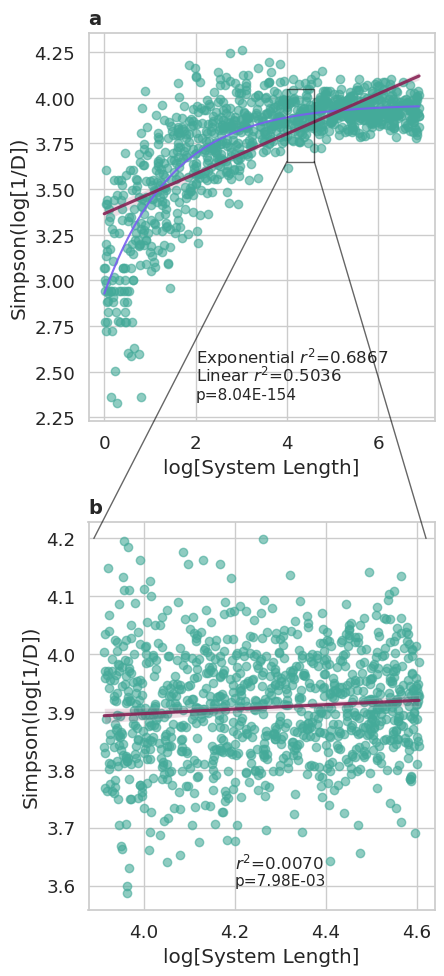

In [39]:
sns.set_theme(style='whitegrid', font_scale=1.2)
fig, axs = plt.subplots(2,1,figsize=(5,10), tight_layout=True)
fig.subplots_adjust(left=0.5, right=0.6, top=0.5)

x='Length'
y ='Simpson'

axs[0] = sns.regplot(data=animal, ax=axs[0], x=x, y=y, \
            scatter_kws={'alpha':0, 'color':'#44AA99'},\
            line_kws={'color':'#882255', 'alpha':0.9, 'zorder':5})
axs[0].plot(x_samp, y_samp, 'ro', color='#44AA99', alpha=0.6, label="Original Noised Data")
axs[0].plot(x_samp, y_fit, '-', color='#785EF0', alpha=0.9, label="Fitted Curve")
# axs[.xlabel('log[System Length').ylabel('Simpson(log[1/D])')
axs[0].set(xlabel='log[System Length]', ylabel='Simpson(log[1/D])')
axs[0].set_title('a', loc='left', fontweight='bold', fontsize=14)
axs[0].text(2,2.35, a_p, fontsize=11)
axs[0].text(2,2.45, f'Linear $r^2$={a_rsq:.4f}', fontsize=12)

# axs[0].text(2,2.05, f'Chi-Square p={chi_sq_pval}', fontsize=11)
axs[0].text(2,2.55, f'Exponential $r^2$={exponential_a_rsq:.4f}', fontsize=12)
axs[1] = sns.regplot(data=human, ax=axs[1], x=x, y=y,logx=True,\
            scatter_kws={'alpha':0.6, 'color':'#44AA99'},\
            line_kws={'color':'#882255', 'alpha':0.9})
                   
axs[1].set(xlabel='log[System Length]', ylabel='Simpson(log[1/D])')
axs[1].set_title('b',loc='left', fontweight='bold', fontsize=14) 
axs[1].text(4.2, 3.6, h_p, fontsize=11)
axs[1].text(4.2, 3.63, f'$r^2$={h_rsq:.4f}',fontsize=12)

rectangle=Rectangle((4,3.65),0.6,0.4, color='black', alpha=0.6, fill=False)
axs[0].add_patch(rectangle).set_zorder(5)
con1 = ConnectionPatch(xyA=(4,3.65), xyB=(3.89, 4.2), coordsA='data', coordsB='data',\
                      axesA=axs[0], axesB=axs[1], color='black', linewidth=1, alpha=0.6)
con1.set_zorder(5)
con2 = ConnectionPatch(xyA=(4.6,3.65), xyB=(4.62,4.2), coordsA='data', coordsB='data',\
                      axesA=axs[0], axesB=axs[1], color='black', linewidth=1, alpha=0.6)
con2.set_zorder(5)
fig.add_artist(con1)
fig.add_artist(con2)


In [40]:
fig.savefig(genpath+'/output/sim_data.pdf')
fig.savefig(genpath+'output/sim_data.png')

### Exponential fit regression

In [ ]:
animal.describe()

In [ ]:
# import numpy as np

# import matplotlib.pyplot as plt

# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import FunctionTransformer

# transformer = FunctionTransformer(np.log, validate=True)

# # Data
# # x_samp, y_samp = np.array([[i] for i in animal['Length']]), np.array([[i] for i in animal['Simpson']])
# x_samp, y_samp = generate_data(func_log, 2.5, 1.2, 0.7, jitter=0.15)
# x_trans = transformer.fit_transform(x_samp)             # 1

# # Regression
# regressor = LinearRegression()
# results = regressor.fit(x_trans, y_samp)                # 2
# model = results.predict
# y_fit = model(x_trans)

# # Visualization
# plt.scatter(x_samp, y_samp)
# plt.plot(x_samp, y_fit, "k--", label="Fit")             # 3
# plt.title("Logarithmic Fit")

In [ ]:
# x_samp, y_samp = animal['Length'].values.reshape(1,-1), animal['Simpson'].values.reshape(1,-1)
# x_samp, y_samp = np.empty(shape=1), np.empty(shape=1)
x_samp, y_samp = np.array([[i] for i in animal['Length']], dtype=float).flatten(), np.array([[i] for i in animal['Simpson']], dtype=float).flatten()
x_samp.shape

In [ ]:
print(popt, pcov)

In [ ]:
# Get r^2 value
residuals = y - func(x, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print(r_squared)

In [ ]:
# Plot y versus residuals
plt.plot(func(x, *popt), residuals, "o", label="Data")

In [ ]:
def f_wrapper_for_odr(beta, x): # parameter order for odr
    return func(x, *beta)

# Use parameters determined by scipy curve_fit
parameters, cov= popt, pcov

# Create ODR based on inverse exponential function
model = scipy.odr.odrpack.Model(f_wrapper_for_odr)
data = scipy.odr.odrpack.Data(x,y)
myodr = scipy.odr.odrpack.ODR(data, model, beta0=parameters)
parameterStatistics = myodr.run()

# Calculate confidence intervals for each parameter
df_e = len(x) - len(parameters) # degrees of freedom, error
cov_beta = parameterStatistics.cov_beta # parameter covariance matrix from ODR
sd_beta = parameterStatistics.sd_beta * parameterStatistics.sd_beta
ci = []
t_df = scipy.stats.t.ppf(0.975, df_e)
ci = []
for i in range(len(parameters)):
    ci.append([parameters[i] - t_df * parameterStatistics.sd_beta[i], parameters[i] + t_df * parameterStatistics.sd_beta[i]])

tstat_beta = parameters / parameterStatistics.sd_beta # coeff t-statistics
pstat_beta = (1.0 - scipy.stats.t.cdf(np.abs(tstat_beta), df_e)) * 2.0    # coef. p-values

for i in range(len(parameters)):
    print('parameter:', parameters[i])
    print('   conf interval:', ci[i][0], ci[i][1])
    print('   tstat:', tstat_beta[i])
    print('   pstat:', pstat_beta[i])
    print()
    
parameterStatistics.pprint()

In [ ]:
regressor = lmfit.models.ExponentialModel()                # 1    
initial_guess = dict(amplitude=1, decay=-1)                # 2
results = regressor.fit(y_samp, x=x_samp, **initial_guess)
y_fit = results.best_fit    

plt.plot(x_samp, y_samp, "o", label="Data")
plt.plot(x_samp, y_fit, "k--", label="Fit")
plt.legend()

In [ ]:

scipy.stats.f_oneway(y, yfit, axis=0)

# fig.savefig('/proj/gibbons/kramos/github/IBT-and-the-Gut-Microbiome/output/sim_data.pdf')